## Stack Exchange Post text classifiction using Fasttext.

**_Authenticating the google colab with Google SDK_**

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


**_loading required libraries_**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
%matplotlib inline
nltk.download("stopwords")
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**_Querying Google Cloud Platform_**

_We have connected to Google cloud Platform using a project id (assigned to every user) and then ran a select query with limit to fetch only 500000 records on **stackoverflow_posts** table from the **bigquery public data  stackoverflow database** and created a dataframe._

In [3]:
#Project Id for google cloud platform
project_id = 'commanding-iris-288015'

stack_ex_data = pd.io.gbq.read_gbq('''
  SELECT * FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
  LIMIT 500000
''', project_id=project_id, dialect='standard')

print("Shape of the Stackexchange dataset:", stack_ex_data.shape)
stack_ex_data.head()

Shape of the Stackexchange dataset: (500000, 20)


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086.0,1.0,2,NaT,2009-02-08 02:55:56.867000+00:00,65,2016-04-10 03:28:09.653000+00:00,2015-08-15 10:24:12.720000+00:00,None,1529129.0,Isaac Waller,764272.0,NaN,1,132,android|url|android-intent|intentfilter|launch,91060.0
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762.0,1.0,0,NaT,2013-01-02 20:31:53.523000+00:00,4,2013-01-02 20:34:55.003000+00:00,NaT,None,NaN,user1499731,NaN,NaN,1,13,java|eclipse,4272.0
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806.0,2.0,0,NaT,2008-08-21 18:35:04.410000+00:00,5,2015-11-30 02:03:49.403000+00:00,2015-11-30 02:03:49.403000+00:00,None,1321.0,whatknott,1321.0,NaN,1,13,winforms|deployment|clickonce,2534.0
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972.0,2.0,2,NaT,2011-06-30 07:33:38.647000+00:00,4,2014-04-22 17:16:44.230000+00:00,2012-01-24 07:37:04.003000+00:00,user83950,NaN,user83950,NaN,NaN,1,7,ios4|uikit,2837.0
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223.0,2.0,3,NaT,2009-02-27 01:30:27.723000+00:00,6,2012-01-12 01:44:40.020000+00:00,2012-01-12 01:44:40.020000+00:00,None,8677.0,I. J. Kennedy,8677.0,NaN,1,21,c#|delegates|action,12377.0


## _Exploratory Analysis_

**_Keeping only important columns in the dataframe for further analysis_**

In [4]:
stack_ex_clean_data = stack_ex_data[["tags","body","answer_count","creation_date","last_activity_date"]]

#Pre-processing answer_count column.
stack_ex_clean_data["answer_count"]=stack_ex_clean_data["answer_count"].fillna(0)
stack_ex_clean_data["answer_count"]=stack_ex_clean_data["answer_count"].astype(int)

_Plotting the graph for top 20 answer counts( answer counts ~ shows how many answers have been posted for every post)_

In [5]:
posts_answer_counts = pd.DataFrame()
posts_answer_counts= stack_ex_clean_data["answer_count"].value_counts(ascending=False)

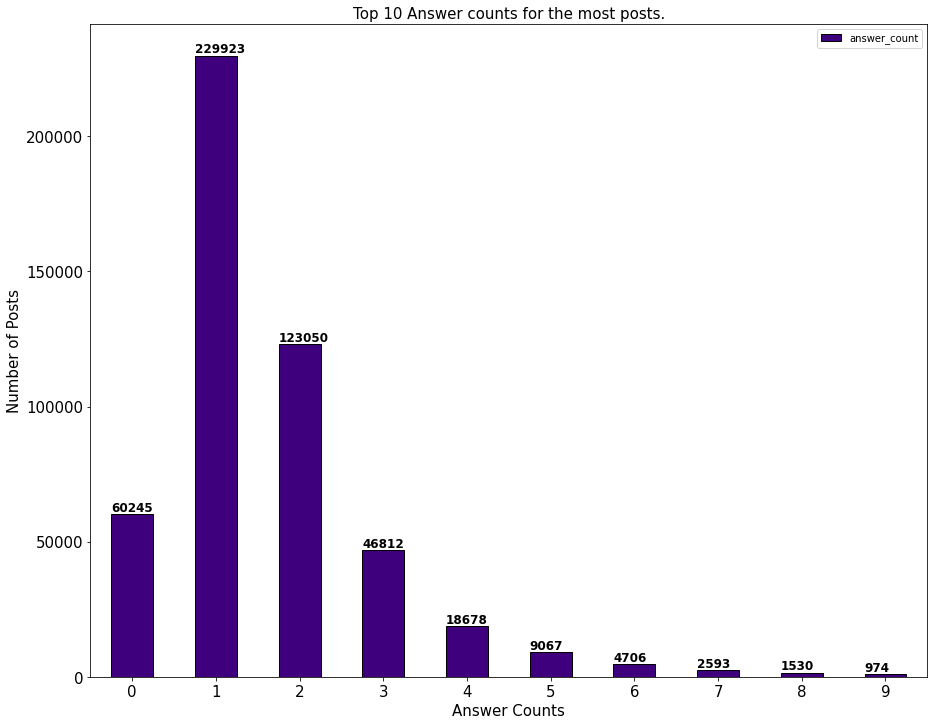

In [6]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=posts_answer_counts[:10].sort_index(ascending=True).plot.bar(x='answer_counts',
                      ax=ax,fontsize=15,cmap="Purples_r" ,edgecolor="black")

ax.set_title("Top 10 Answer counts for the most posts.",size=15)
ax.legend().remove()
plt.xlabel("Answer Counts",size=15)
plt.ylabel("Number of Posts",size=15)

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360)
plt.show()

In [7]:
posts_wo_answer=posts_answer_counts[0]

print("The",(posts_wo_answer/500000)*100,"% posts have no answers on the StackOverflow.")

The 12.049 % posts have no answers on the StackOverflow.


**_We observe that 12.049% posts on the StackOverflow are unanswered._**

In [8]:
stack_ex_clean_data['creation_date'] = pd.to_datetime(stack_ex_clean_data['creation_date']) #converting created_at column to datetime

In [9]:
stack_ex_clean_data['creation_hour'] = stack_ex_clean_data['creation_date'].dt.hour #creating hour column 201701010001
stack_ex_clean_data['create_date_sh'] = stack_ex_clean_data['creation_date'].dt.date
stack_ex_clean_data['only_date'] = stack_ex_clean_data['creation_date'].apply(lambda x : str(x)[8:10])

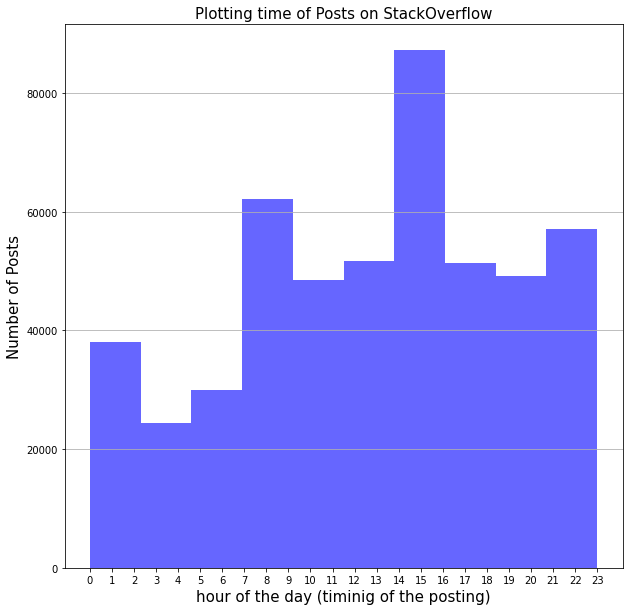

In [10]:
fig = plt.figure(figsize = (10,10)) #figsize
plt.hist(stack_ex_clean_data['creation_hour'], color=['blue'],alpha=0.6) 
plt.xlabel("hour of the day (timinig of the posting)",size=15) 
plt.ylabel("Number of Posts",size=15) #setting y axis label
plt.xticks(range(0,24)) #setting x axis ticks 
plt.grid(axis='y')
plt.title('Plotting time of Posts on StackOverflow',size=15)
plt.show()

**_We observe that the throughout the day people are posting posts on the StackOverflow. People posts most of the tweets starting from 0700 hours and between 1400 hours to 1500 hours posting is at peak._**

**_Removing the hyperlinks and tags as well_**

In [11]:
stack_ex_clean_data["body"] = stack_ex_clean_data["body"].str.replace("<.*?>", " ")
stack_ex_clean_data["body"] = stack_ex_clean_data["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

**_changing the case of the words in the tags column_**

In [12]:
# stop_words = set(stopwords.words("english"))
stack_ex_clean_tags = ' '.join(stack_ex_clean_data['tags'].str.lower())

**_Printing Word cloud of the tags_**

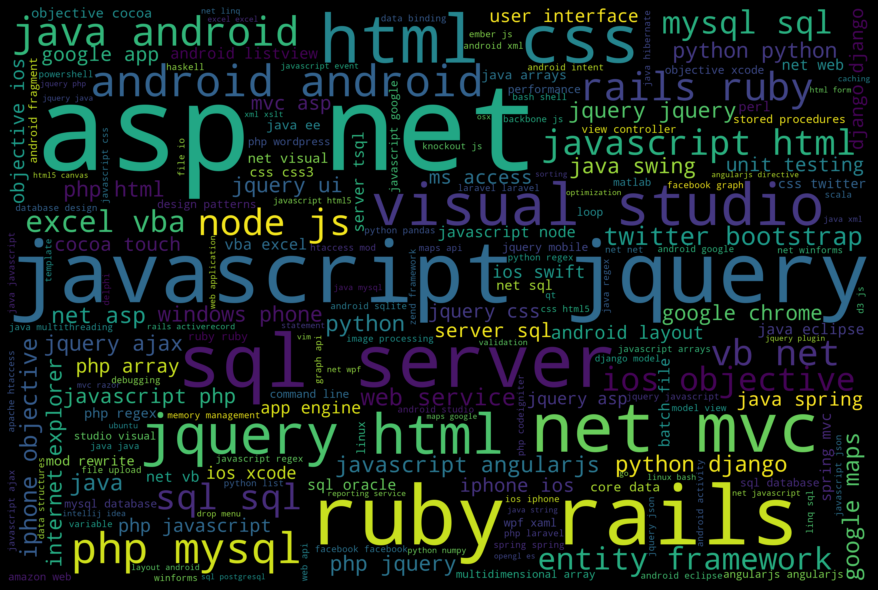

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(stack_ex_clean_tags)
fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**_Making label column as per requirement for input to the fasttext module._**

In [14]:
stack_ex_clean_data["tags"] = [item.replace("|", " __label__") for item in stack_ex_clean_data["tags"]]
stack_ex_clean_data['tags'] ='__label__' + stack_ex_clean_data['tags'].astype(str)

In [15]:
stack_ex_clean_data[["tags","body"]].head()

,tags,body
0,__label__android __label__url __label__android...,I want my intent to be launched when the user...
1,__label__java __label__eclipse,I used to see both Building and Cleaning acti...
2,__label__winforms __label__deployment __label_...,Our team develops distributed winform apps. W...
3,__label__ios4 __label__uikit,In an iOS app I need to provide image filters...
4,__label__c# __label__delegates __label__action,I see this line in many online examples of us...
